# Baseline SVM Models

Before Running this notebook, run the notebook 'Pre-Processed.ipynb' (Located in cmse492_project\Data\Pre-Processing) which will create the processed dataframe file 'processed.csv'. Place a copy of that file into this directory (cmse492_project\Models\SVMModels)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, recall_score, f1_score
from sklearn.utils import resample
from sklearn.pipeline import Pipeline, make_pipeline

**I. Resampling Dataframe for Smaller Sample (284,807 -> 34,440)**

In [33]:
dfo = pd.read_csv('processed.csv') #dfo = original dataframe
minority_class = dfo[dfo['Class'] == 1]
majority_class = dfo[dfo['Class'] == 0]

majority_class_downsampled = resample(
    majority_class,
    replace=False,  
    n_samples=len(minority_class) * 70,  # Size of the majority class after downsampling
    random_state=42
)



df = pd.concat([minority_class, majority_class_downsampled]) #subsampled
print(len(minority_class) * 70)
print('Reduction to', (len(minority_class) * 70)/len(majority_class) * 100, '% of the original majority class')

34440
Reduction to 12.113325009232717 % of the original majority class


**II. Test Train Split**

In [34]:
X = df.drop(['Class', 'Time', 'TransactionTime'], axis=1)  
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

**III. Creating Pipelines and Cross Validation**

In [39]:
pipeline_linear = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', class_weight='balanced', random_state=42, probability = True)
)

pipeline_rbf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', class_weight='balanced', random_state=42, probability = True), 
)

In [29]:
cv_scores_linear = []
for fold in tqdm(range(5), desc="Linear Kernel", position=0):
    score = cross_val_score(pipeline_linear, X_train, y_train, cv=5)[fold]
    cv_scores_linear.append(score)

Linear Kernel: 100%|████████████████████████████████████████████████████████████████████| 5/5 [09:31<00:00, 114.25s/it]


In [30]:
cv_scores_rbf = []
for fold in tqdm(range(5), desc="RBF Kernel", position=1):
    score = cross_val_score(pipeline_rbf, X_train, y_train, cv=5)[fold]
    cv_scores_rbf.append(score)



RBF Kernel: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.86s/it]


In [27]:
print(f"Linear Kernel - Mean CV: {np.mean(cv_scores_linear):.4f}, Std: {np.std(cv_scores_linear):.4f}")
print(f"RBF Kernel - Mean CV: {np.mean(cv_scores_rbf):.4f}, Std: {np.std(cv_scores_rbf):.4f}")


Linear Kernel - Mean CV: 0.9760, Std: 0.0026
RBF Kernel - Mean CV: 0.9905, Std: 0.0010


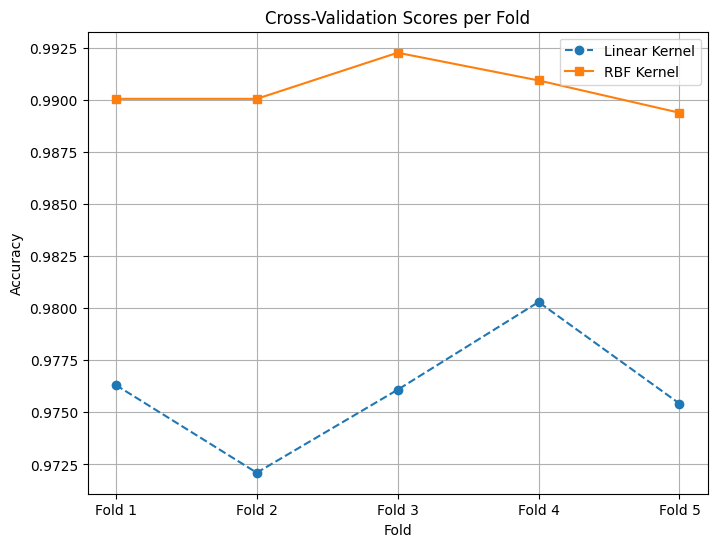

In [35]:

plt.figure(figsize=(8, 6))
plt.plot(cv_scores_linear, marker='o', label='Linear Kernel', linestyle='--')
plt.plot(cv_scores_rbf, marker='s', label='RBF Kernel', linestyle='-')

plt.title('Cross-Validation Scores per Fold')
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.xticks(range(len(cv_scores_linear)), [f'Fold {i+1}' for i in range(len(cv_scores_linear))])
plt.legend()
plt.grid()
plt.show()


**IV. Fitting Models**

In [41]:
pipeline_rbf.fit(X_train, y_train)
pipeline_linear.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])

**V. Assessing Model Effectiveness with AUROC, recall, and F1-Score**

Linear Kernel - AUROC: 0.9684, Recall: 0.8776, F1 Score: 0.5119
RBF Kernel - AUROC: 0.9809, Recall: 0.8776, F1 Score: 0.7611


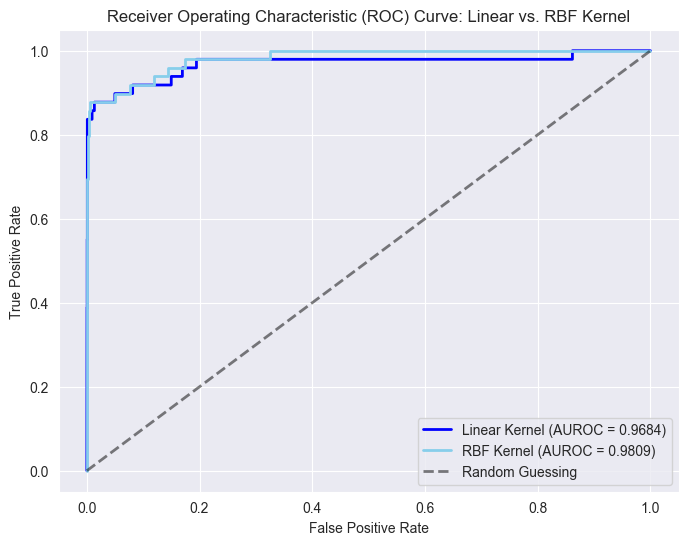

In [48]:
y_pred_probs_linear = pipeline_linear.predict_proba(X_test)[:, 1]  # Linear kernel probabilities
y_pred_probs_rbf = pipeline_rbf.predict_proba(X_test)[:, 1]  # RBF kernel probabilities

#ROC curve and AUROC 
fpr_linear, tpr_linear, thresholds_linear = roc_curve(y_test, y_pred_probs_linear, pos_label=1)
auroc_linear = auc(fpr_linear, tpr_linear)
fpr_rbf, tpr_rbf, thresholds_rbf = roc_curve(y_test, y_pred_probs_rbf, pos_label=1)
auroc_rbf = auc(fpr_rbf, tpr_rbf)

# Get predicted labels for F1 and recall scores
y_pred_linear = pipeline_linear.predict(X_test)
y_pred_rbf = pipeline_rbf.predict(X_test)

# Metrics
recall_linear = recall_score(y_test, y_pred_linear, pos_label=1)
f1_linear = f1_score(y_test, y_pred_linear, pos_label=1)


recall_rbf = recall_score(y_test, y_pred_rbf, pos_label=1)
f1_rbf = f1_score(y_test, y_pred_rbf, pos_label=1)


print(f"Linear Kernel - AUROC: {auroc_linear:.4f}, Recall: {recall_linear:.4f}, F1 Score: {f1_linear:.4f}")
print(f"RBF Kernel - AUROC: {auroc_rbf:.4f}, Recall: {recall_rbf:.4f}, F1 Score: {f1_rbf:.4f}")

#AUROC plot
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plt.plot(fpr_linear, tpr_linear, color="blue", lw=2, label=f"Linear Kernel (AUROC = {auroc_linear:.4f})")


plt.plot(fpr_rbf, tpr_rbf, color="skyblue", lw=2, label=f"RBF Kernel (AUROC = {auroc_rbf:.4f})")
plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--", label="Random Guessing", alpha = .5)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve: Linear vs. RBF Kernel")
plt.legend(loc="lower right")
plt.show()
